In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

2022-12-02 22:07:03.267627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 22:07:04.534962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/users/skoka/.conda/envs/ml_env_2/lib/
2022-12-02 22:07:04.535060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/users/skoka/.conda/envs/ml_env_2/lib/
2022-12-02 22:07:04.535069: W tensorflow/c

In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-12-02 22:07:07.649912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 22:07:08.393233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 30971 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


True

In [3]:
strategy = tf.distribute.MirroredStrategy()

# Print the number of devices in the strategy's MirroredStrategy object
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2022-12-02 22:07:08.413097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30971 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


# Evaluation Metric:

Accuracy:
Because the classes in our dataset are balanced, and there is no added benefit (from a buisness perspective) for our model to better predict one of the classes than the others, Accuracy is a good metric to use to judge our models 

## Loading in the Data:

In [4]:
files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]
dir = "cifar-10-batches-py/"

# Loading the data into a single numpy array:
for file in files:
    with open(dir + file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        if file == "data_batch_1":
            data = dict[b'data']
            labels = dict[b'labels']
        else:
            data = np.vstack((data, dict[b'data']))
            labels = np.hstack((labels, dict[b'labels']))



data = data.reshape((data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1).astype("int")

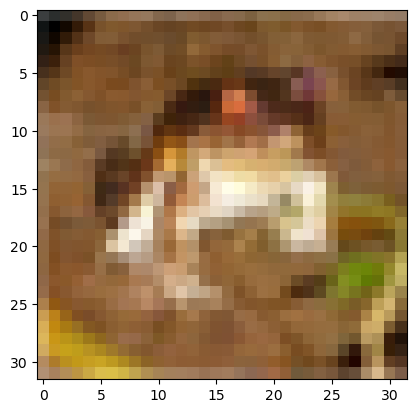

In [5]:
# plot the first image of cifar 10 dataset:
plt.imshow(data[0], interpolation='nearest')

# Splitting the Data:

We will use a stratified train test split. We have enough data, 60,000 images equally split amoungst 10 classes. Therefore, we do not need to use K-fold cross validation or shuffle split in order to properly train and evaluate our models.


In [6]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=69, stratify=labels)

# Modeling

In [20]:
def plot_history(history):
    # plot history of the model:
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validate')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')

## Model 1:

In [44]:
datagen = ImageDataGenerator()
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)
model1 = tf.keras.Model(inputs=input, outputs=output)

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


2022-12-04 13:18:59.243778: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-04 13:18:59.468033: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-04 13:18:59.622564: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

188/188 [==============================] - 3s 12ms/step - loss: 1.8989 - accuracy: 0.3067 - val_loss: 1.6021 - val_accuracy: 0.4121
Epoch 2/20
188/188 [==============================] - 2s 10ms/step - loss: 1.4994 - accuracy: 0.4519 - val_loss: 1.4303 - val_accuracy: 0.4857
Epoch 3/20
188/188 [==============================] - 2s 10ms/step - loss: 1.3496 - accuracy: 0.5155 - val_loss: 1.3224 - val_accuracy: 0.5236
Epoch 4/20
188/188 [==============================] - 2s 10ms/step - loss: 1.2476 - accuracy: 0.5556 - val_loss: 1.2495 - val_accuracy: 0.5515
Epoch 5/20
188/188 [==============================] - 2s 10ms/step - loss: 1.1813 - accuracy: 0.5820 - val_loss: 1.2046 - val_accuracy: 0.5726
Epoch 6/20
188/188 [==============================] - 2s 10ms/step - loss: 1.1278 - accuracy: 0.6017 - val_loss: 1.2405 - val_accuracy: 0.5637
Epoch 7/20
188/188 [==============================] - 2s 10ms/step - loss: 1.0897 - accuracy: 0.6157 - val_loss: 1.1318 - val_accuracy: 0.6012
Epoch 8/20

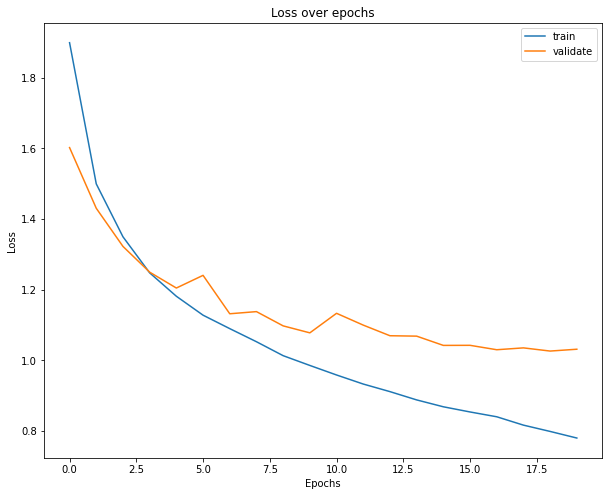

In [48]:
# plot the accuracy and loss of the model:
plot_history(history1)

As seen by the diverging train and validation loss graphs, the model is overfitting and validation accuracy is maxing out at around 62% while the training accuracy peaks at around 74%. In order to combat this we will add dropout in the next model to prevent overfitting.

## Model 1.5

In [45]:
datagen = ImageDataGenerator(rotation_range=5)
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)
model1_5 = tf.keras.Model(inputs=input, outputs=output)

model1_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history1_5 = model1_5.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=30, validation_data=(X_val, y_val))

Epoch 1/30


2022-12-04 13:19:37.908220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


188/188 [==============================] - 11s 50ms/step - loss: 1.9908 - accuracy: 0.2606 - val_loss: 1.6934 - val_accuracy: 0.4055
Epoch 2/30
188/188 [==============================] - 9s 49ms/step - loss: 1.6163 - accuracy: 0.4013 - val_loss: 1.4919 - val_accuracy: 0.4807
Epoch 3/30
188/188 [==============================] - 9s 50ms/step - loss: 1.4918 - accuracy: 0.4520 - val_loss: 1.3718 - val_accuracy: 0.5177
Epoch 4/30
188/188 [==============================] - 10s 51ms/step - loss: 1.4083 - accuracy: 0.4831 - val_loss: 1.3264 - val_accuracy: 0.5357
Epoch 5/30
188/188 [==============================] - 9s 49ms/step - loss: 1.3477 - accuracy: 0.5084 - val_loss: 1.2809 - val_accuracy: 0.5475
Epoch 6/30
188/188 [==============================] - 9s 48ms/step - loss: 1.3062 - accuracy: 0.5224 - val_loss: 1.2829 - val_accuracy: 0.5577
Epoch 7/30
188/188 [==============================] - 9s 49ms/step - loss: 1.2760 - accuracy: 0.5352 - val_loss: 1.1982 - val_accuracy: 0.5811
Epoch 8/

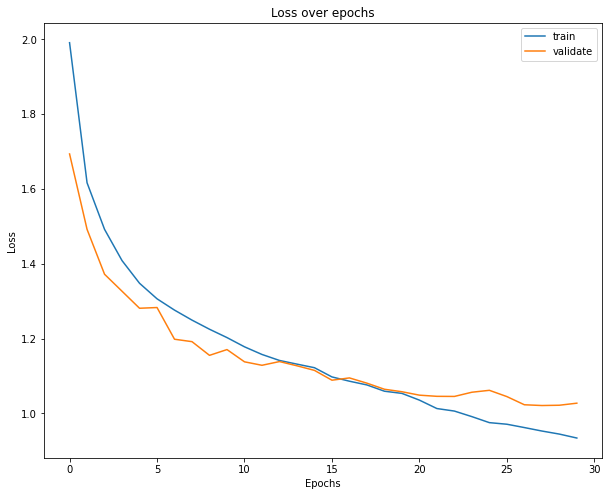

In [47]:
plot_history(history1_5)

This time we can see that the train loss and validation loss 

## McNemar Test to test differences between model1 and model1_5

In [12]:
y_pred_model1 = model1.predict(X_val)
y_pred_model1_5 = model1_5.predict(X_val)

y_pred_model1 = np.argmax(y_pred_model1, axis=1)
y_pred_model1_5 = np.argmax(y_pred_model1_5, axis=1)


model1_correct = np.sum((y_pred_model1 == y_val) & (y_pred_model1_5 != y_val))
model1_5_correct = np.sum((y_pred_model1_5 == y_val) & (y_pred_model1 != y_val))

critical_value = (model1_correct + model1_5_correct)**2 / (model1_correct + model1_5_correct)
from scipy.stats import chi2
import math

p = 1 - chi2.cdf(math.sqrt(critical_value), 1)


In [13]:
p

1.0897949209720537e-12

## Model 2:

In [46]:
datagen = ImageDataGenerator()
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)

dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(32, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model2 = tf.keras.Model(inputs=input, outputs=output)

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=512), epochs=35, validation_data=(X_val, y_val))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_239 (Conv2D)         (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_224 (Ba  (None, 30, 30, 16)       64        
 tchNormalization)                                               
                                                                 
 dropout_9 (Dropout)         (None, 30, 30, 16)        0         
                                                                 
 conv2d_240 (Conv2D)         (None, 28, 28, 16)        2320      
                                                          

2022-12-04 13:24:18.417380: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-04 13:24:18.938329: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 3/94 [..............................] - ETA: 4s - loss: 2.4785 - accuracy: 0.0892

2022-12-04 13:24:20.612166: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


94/94 [==============================] - 10s 74ms/step - loss: 2.1419 - accuracy: 0.1771 - val_loss: 2.2927 - val_accuracy: 0.1525
Epoch 2/35
94/94 [==============================] - 6s 61ms/step - loss: 1.8416 - accuracy: 0.2866 - val_loss: 2.3030 - val_accuracy: 0.1547
Epoch 3/35
94/94 [==============================] - 6s 60ms/step - loss: 1.7311 - accuracy: 0.3453 - val_loss: 2.4209 - val_accuracy: 0.1577
Epoch 4/35
94/94 [==============================] - 6s 61ms/step - loss: 1.6492 - accuracy: 0.3805 - val_loss: 2.4055 - val_accuracy: 0.1902
Epoch 5/35
94/94 [==============================] - 6s 61ms/step - loss: 1.5906 - accuracy: 0.4064 - val_loss: 2.3880 - val_accuracy: 0.2057
Epoch 6/35
94/94 [==============================] - 6s 61ms/step - loss: 1.5462 - accuracy: 0.4239 - val_loss: 1.8621 - val_accuracy: 0.3304
Epoch 7/35
94/94 [==============================] - 6s 61ms/step - loss: 1.5050 - accuracy: 0.4412 - val_loss: 1.7160 - val_accuracy: 0.3916
Epoch 8/35
94/94 [=====

In [15]:
model2.save('model2.h5')

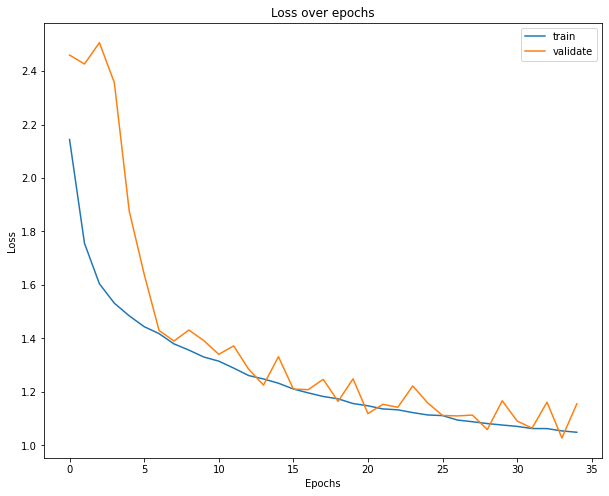

In [16]:
plot_history(history2)

## Model 2.5:

In [20]:
datagen = ImageDataGenerator()
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model2_5 = tf.keras.Model(inputs=input, outputs=output)

model2_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history2_5 = model2_5.fit(datagen.flow(X_train, y_train, batch_size=512), epochs=35, validation_data=(X_val, y_val))

Epoch 1/35


2022-12-03 23:39:39.121844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-03 23:39:42.061960: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-03 23:39:42.148242: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.

 1/94 [..............................] - ETA: 9:57 - loss: 2.7065 - accuracy: 0.1055

2022-12-03 23:39:44.674853: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


94/94 [==============================] - 33s 282ms/step - loss: 2.1344 - accuracy: 0.1737 - val_loss: 2.3306 - val_accuracy: 0.1153
Epoch 2/35
94/94 [==============================] - 23s 242ms/step - loss: 1.6912 - accuracy: 0.3635 - val_loss: 2.7008 - val_accuracy: 0.1524
Epoch 3/35
94/94 [==============================] - 23s 243ms/step - loss: 1.4221 - accuracy: 0.4765 - val_loss: 3.5781 - val_accuracy: 0.1024
Epoch 4/35
94/94 [==============================] - 23s 244ms/step - loss: 1.2781 - accuracy: 0.5341 - val_loss: 4.3062 - val_accuracy: 0.1024
Epoch 5/35
94/94 [==============================] - 23s 244ms/step - loss: 1.1856 - accuracy: 0.5756 - val_loss: 3.1952 - val_accuracy: 0.1467
Epoch 6/35
94/94 [==============================] - 23s 244ms/step - loss: 1.1150 - accuracy: 0.5967 - val_loss: 1.6735 - val_accuracy: 0.4073
Epoch 7/35
94/94 [==============================] - 23s 244ms/step - loss: 1.0575 - accuracy: 0.6227 - val_loss: 1.2810 - val_accuracy: 0.5522
Epoch 8/35

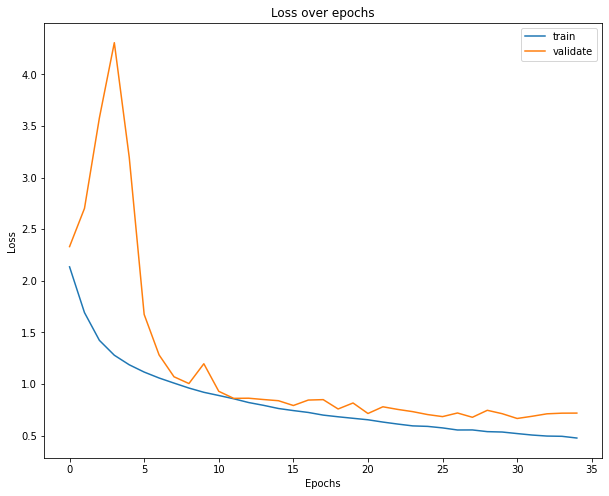

In [21]:
plot_history(history2_5)

## Standard MLP:

In [28]:
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

dense = tf.keras.layers.Flatten()(normalized_input)
dense = tf.keras.layers.Dense(1024, activation='relu')(dense)
dense = tf.keras.layers.Dense(512, activation='relu')(dense)
dense = tf.keras.layers.Dense(256, activation='relu')(dense)

output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model_mpl = tf.keras.Model(inputs=input, outputs=output)

model_mpl.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_mpl = model_mpl.fit(datagen.flow(X_train, y_train, batch_size=512), epochs=23, validation_data=(X_val, y_val))


Epoch 1/23
94/94 [==============================] - 2s 15ms/step - loss: 2.0906 - accuracy: 0.2573 - val_loss: 1.8582 - val_accuracy: 0.3344
Epoch 2/23
94/94 [==============================] - 1s 12ms/step - loss: 1.7783 - accuracy: 0.3640 - val_loss: 1.7516 - val_accuracy: 0.3633
Epoch 3/23
94/94 [==============================] - 1s 12ms/step - loss: 1.6674 - accuracy: 0.4038 - val_loss: 1.6472 - val_accuracy: 0.4157
Epoch 4/23
94/94 [==============================] - 1s 13ms/step - loss: 1.6011 - accuracy: 0.4289 - val_loss: 1.6067 - val_accuracy: 0.4294
Epoch 5/23
94/94 [==============================] - 1s 12ms/step - loss: 1.5454 - accuracy: 0.4490 - val_loss: 1.5679 - val_accuracy: 0.4452
Epoch 6/23
94/94 [==============================] - 1s 12ms/step - loss: 1.4973 - accuracy: 0.4674 - val_loss: 1.5275 - val_accuracy: 0.4621
Epoch 7/23
94/94 [==============================] - 1s 12ms/step - loss: 1.4686 - accuracy: 0.4759 - val_loss: 1.5168 - val_accuracy: 0.4656
Epoch 8/23
94

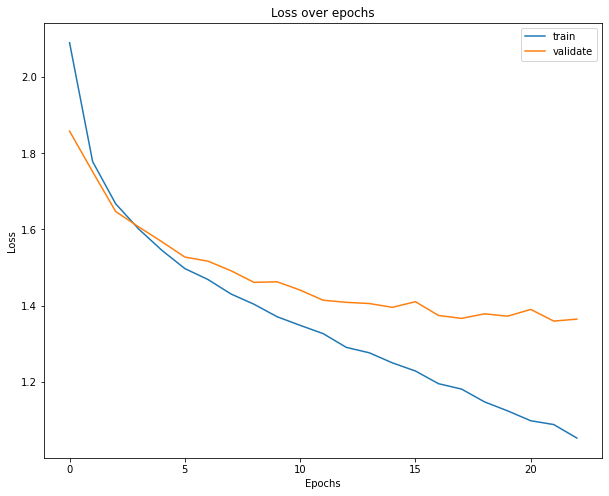

In [29]:
plot_history(history_mpl)

The validation loss converges at around 15 epochs but the training loss diverges significantly from the validation loss. 

## Comparing the five models:

In [25]:
model1 = tf.keras.models.load_model('model1.h5')
model2 = tf.keras.models.load_model('model2.h5')
model2_5 = tf.keras.models.load_model('model2_5.h5')
model_mpl = tf.keras.models.load_model('model_mpl.h5')
model1_5 = tf.keras.models.load_model('model1_5.h5')
model3 = tf.keras.models.load_model('model3.h5')

In [28]:
# Calcaulte AUC for each class:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def average_auc(model):
    global y_val
    global X_val
    y_pred = model.predict(X_val)
    y_pred_guess = np.argmax(y_pred, axis=1)
    sum = 0

    for i in range(10):
        y_val_one = np.where(y_val != i, 0, 1)
        y_pred_one = y_pred[:,i]
        fpr, tpr, trash = roc_curve(y_val_one, y_pred_one)
        sum += auc(fpr, tpr)

    return sum/10

def plot_roc(model):
    #plot ROC curve for each class without OneHotEncoding:
    global y_val
    global X_val
    y_pred = model.predict(X_val)
    y_pred_guess = np.argmax(y_pred, axis=1)


    for i in range(10):

        # make a new NP array which is 1 if the class is the current class and 0 otherwise:
        y_val_one = np.where(y_val != i, 0, 1)
        y_pred_one = y_pred[:,i]

        fpr, tpr, trash = roc_curve(y_val_one, y_pred_one)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='class {} (area = {:.2f})'.format(i, auc_score))
    
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    return plt

375/375 [==============================] - 26s 70ms/step
Average AUC for model 2.5: 0.971221724537037
375/375 [==============================] - 2s 6ms/step
Average AUC for standard MLP: 0.8959808333333333
375/375 [==============================] - 25s 67ms/step


AttributeError: 'NoneType' object has no attribute 'title'

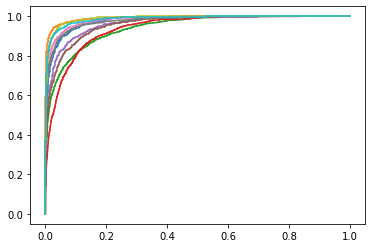

In [30]:
print("Average AUC for model 2.5: " + str(average_auc(model2_5)))
print("Average AUC for standard MLP: " + str(average_auc(model_mpl)))
plt = plot_roc(model2_5)
plt.title('ROC Curve for model 2.5')


In [ ]:
#plot Roc curve for model 2.5 and standard MLP:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def plot_roc(model):
    global y_val
    global X_val
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=1)

    # compute the AUC score for each class with One Vs Rest:
    y_val_one_hot = label_binarize(y_val, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    y_pred_one_hot = label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    for i in range(10):
        fpr, tpr, trash = roc_curve(y_val_one_hot[:, i], y_pred_one_hot[:, i])
        plt.plot(fpr, tpr, label='Class ' + str(i) + ' AUC: ' + str(auc(fpr, tpr)))

    plt.legend()
    plt.show()


## Exceptional Work - Creating a 56 layer residual network



Inspired by: 
https://arxiv.org/pdf/1512.03385.pdf

In [17]:
from tensorflow.keras.regularizers import l2

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(X_train)
    

# Resnet block:
def resnet_block(input, output_filters, strides=1):
    input_filters = input.shape[-1]
    if input_filters != output_filters:
        new_add = tf.keras.layers.Conv2D(output_filters, (1, 1), activation='relu', strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if input_filters != output_filters:
        x = tf.keras.layers.Add()([x, new_add])
    else:
        x = tf.keras.layers.Add()([x, input])
    x = tf.keras.layers.Activation('relu')(x)
    return x

input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)

# resnet block
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 32, 2)
x = resnet_block(x, 32)
x = resnet_block(x, 32)
x = resnet_block(x, 32)
x = resnet_block(x, 32)
x = resnet_block(x, 32)
x = resnet_block(x, 32)
x = resnet_block(x, 32)
x = resnet_block(x, 32)
x = resnet_block(x, 64, 2)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 64)

x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model3 = tf.keras.Model(inputs=input, outputs=output)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.01,
  decay_rate=0.1,
  decay_steps=32000
)


model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule,
                                                  ema_momentum=0.9,
                                                  use_ema=True),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model3.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_5 (Rescaling)        (None, 32, 32, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv2d_285 (Conv2D)            (None, 26, 26, 16)   2368        ['rescaling_5[0][0]']            
                                                                                                  
 batch_normalization_275 (Batch  (None, 26, 26, 16)  64          ['conv2d_285[0][0]']             
 Normalization)                                                                             

 Normalization)                                                                                   
                                                                                                  
 activation_278 (Activation)    (None, 26, 26, 16)   0           ['batch_normalization_284[0][0]']
                                                                                                  
 conv2d_295 (Conv2D)            (None, 26, 26, 16)   2320        ['activation_278[0][0]']         
                                                                                                  
 batch_normalization_285 (Batch  (None, 26, 26, 16)  64          ['conv2d_295[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_139 (Add)                  (None, 26, 26, 16)   0           ['batch_normalization_285[0][0]',
          

                                                                                                  
 batch_normalization_294 (Batch  (None, 13, 13, 32)  128         ['conv2d_305[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_288 (Activation)    (None, 13, 13, 32)   0           ['batch_normalization_294[0][0]']
                                                                                                  
 conv2d_306 (Conv2D)            (None, 13, 13, 32)   9248        ['activation_288[0][0]']         
                                                                                                  
 batch_normalization_295 (Batch  (None, 13, 13, 32)  128         ['conv2d_306[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_297 (Activation)    (None, 13, 13, 32)   0           ['add_148[0][0]']                
                                                                                                  
 conv2d_315 (Conv2D)            (None, 13, 13, 32)   9248        ['activation_297[0][0]']         
                                                                                                  
 batch_normalization_304 (Batch  (None, 13, 13, 32)  128         ['conv2d_315[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_298 (Activation)    (None, 13, 13, 32)   0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_31

 conv2d_323 (Conv2D)            (None, 7, 7, 64)     2112        ['activation_305[0][0]']         
                                                                                                  
 add_153 (Add)                  (None, 7, 7, 64)     0           ['batch_normalization_313[0][0]',
                                                                  'conv2d_323[0][0]']             
                                                                                                  
 activation_307 (Activation)    (None, 7, 7, 64)     0           ['add_153[0][0]']                
                                                                                                  
 conv2d_326 (Conv2D)            (None, 7, 7, 64)     36928       ['activation_307[0][0]']         
                                                                                                  
 batch_normalization_314 (Batch  (None, 7, 7, 64)    256         ['conv2d_326[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_323 (Batch  (None, 7, 7, 64)    256         ['conv2d_335[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_158 (Add)                  (None, 7, 7, 64)     0           ['batch_normalization_323[0][0]',
                                                                  'activation_315[0][0]']         
                                                                                                  
 activation_317 (Activation)    (None, 7, 7, 64)     0           ['add_158[0][0]']                
                                                                                                  
 conv2d_336 (Conv2D)            (None, 7, 7, 64)     36928       ['activation_317[0][0]']         
          

In [18]:
# Train the model
history3 = model3.fit(datagen.flow(X_train, y_train, batch_size=128), epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
375/375 [==============================] - 49s 55ms/step - loss: 2.7726 - accuracy: 0.1865 - val_loss: 2.5208 - val_accuracy: 0.2025
Epoch 2/200
375/375 [==============================] - 19s 52ms/step - loss: 2.0391 - accuracy: 0.3330 - val_loss: 2.0469 - val_accuracy: 0.3227
Epoch 3/200
375/375 [==============================] - 19s 52ms/step - loss: 1.7840 - accuracy: 0.4041 - val_loss: 2.1435 - val_accuracy: 0.3478
Epoch 4/200
375/375 [==============================] - 19s 52ms/step - loss: 1.6420 - accuracy: 0.4510 - val_loss: 1.7697 - val_accuracy: 0.4221
Epoch 5/200
375/375 [==============================] - 19s 52ms/step - loss: 1.5618 - accuracy: 0.4841 - val_loss: 1.7849 - val_accuracy: 0.4420
Epoch 6/200
375/375 [==============================] - 19s 52ms/step - loss: 1.4878 - accuracy: 0.5152 - val_loss: 1.6680 - val_accuracy: 0.4487
Epoch 7/200
375/375 [==============================] - 19s 52ms/step - loss: 1.4328 - accuracy: 0.5455 - val_loss: 1.4472 - val_ac

375/375 [==============================] - 19s 52ms/step - loss: 0.6810 - accuracy: 0.8073 - val_loss: 0.7744 - val_accuracy: 0.7822
Epoch 58/200
375/375 [==============================] - 19s 51ms/step - loss: 0.6943 - accuracy: 0.8021 - val_loss: 0.9064 - val_accuracy: 0.7446
Epoch 59/200
375/375 [==============================] - 19s 51ms/step - loss: 0.6730 - accuracy: 0.8104 - val_loss: 0.7242 - val_accuracy: 0.7945
Epoch 60/200
375/375 [==============================] - 19s 51ms/step - loss: 0.6614 - accuracy: 0.8144 - val_loss: 1.0635 - val_accuracy: 0.7196
Epoch 61/200
375/375 [==============================] - 19s 52ms/step - loss: 0.6574 - accuracy: 0.8156 - val_loss: 0.7922 - val_accuracy: 0.7795
Epoch 62/200
375/375 [==============================] - 19s 51ms/step - loss: 0.6510 - accuracy: 0.8171 - val_loss: 0.7968 - val_accuracy: 0.7700
Epoch 63/200
375/375 [==============================] - 19s 51ms/step - loss: 0.6486 - accuracy: 0.8181 - val_loss: 0.7727 - val_accuracy

375/375 [==============================] - 19s 51ms/step - loss: 0.4674 - accuracy: 0.8676 - val_loss: 0.5571 - val_accuracy: 0.8418
Epoch 114/200
375/375 [==============================] - 19s 52ms/step - loss: 0.4586 - accuracy: 0.8701 - val_loss: 0.6255 - val_accuracy: 0.8261
Epoch 115/200
375/375 [==============================] - 19s 51ms/step - loss: 0.4578 - accuracy: 0.8680 - val_loss: 0.5604 - val_accuracy: 0.8443
Epoch 116/200
375/375 [==============================] - 19s 51ms/step - loss: 0.4573 - accuracy: 0.8706 - val_loss: 0.5535 - val_accuracy: 0.8443
Epoch 117/200
375/375 [==============================] - 19s 52ms/step - loss: 0.4596 - accuracy: 0.8702 - val_loss: 0.5967 - val_accuracy: 0.8295
Epoch 118/200
375/375 [==============================] - 19s 52ms/step - loss: 0.4500 - accuracy: 0.8729 - val_loss: 0.6584 - val_accuracy: 0.8201
Epoch 119/200
375/375 [==============================] - 19s 52ms/step - loss: 0.4526 - accuracy: 0.8718 - val_loss: 0.5178 - val_ac

Epoch 169/200
375/375 [==============================] - 19s 51ms/step - loss: 0.3866 - accuracy: 0.8894 - val_loss: 0.4718 - val_accuracy: 0.8681
Epoch 170/200
375/375 [==============================] - 19s 51ms/step - loss: 0.3902 - accuracy: 0.8885 - val_loss: 0.4666 - val_accuracy: 0.8691
Epoch 171/200
375/375 [==============================] - 19s 52ms/step - loss: 0.3886 - accuracy: 0.8902 - val_loss: 0.4866 - val_accuracy: 0.8657
Epoch 172/200
375/375 [==============================] - 19s 51ms/step - loss: 0.3874 - accuracy: 0.8909 - val_loss: 0.5163 - val_accuracy: 0.8545
Epoch 173/200
375/375 [==============================] - 19s 51ms/step - loss: 0.3892 - accuracy: 0.8908 - val_loss: 0.5090 - val_accuracy: 0.8608
Epoch 174/200
375/375 [==============================] - 19s 51ms/step - loss: 0.3854 - accuracy: 0.8897 - val_loss: 0.4822 - val_accuracy: 0.8658
Epoch 175/200
375/375 [==============================] - 19s 52ms/step - loss: 0.3866 - accuracy: 0.8897 - val_loss: 0

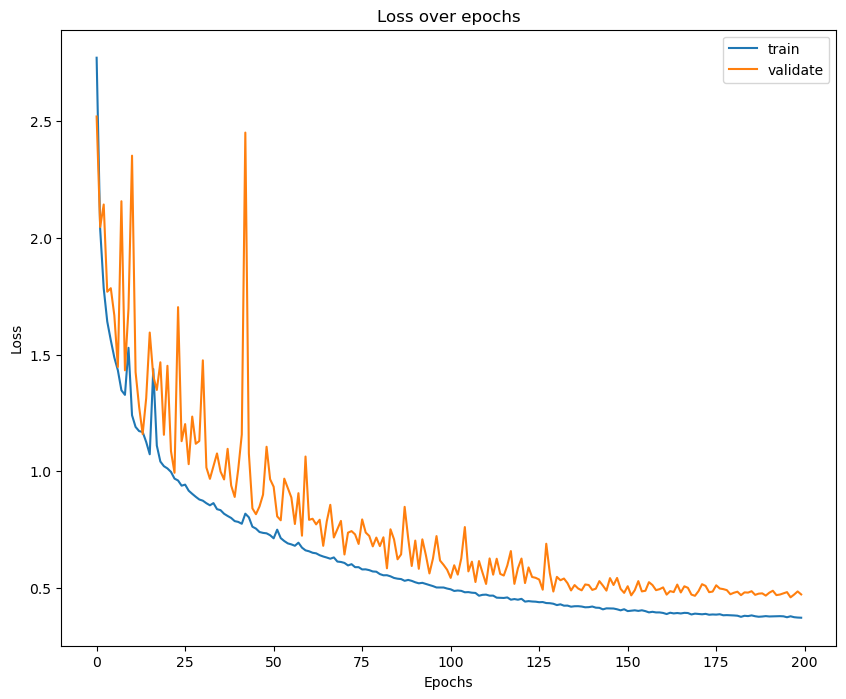

In [21]:
plot_history(history3)

The model takes around 150 epochs to convege. The validation loss suddenly decreases its volatility around 125 epochs, this is likley due to the decrease in learning rate happening around this epoch.

In [22]:
model3.save('model3.h5')

In [16]:
model3 = tf.keras.models.load_model('model3.h5')

In [68]:
model3.evaluate(X_val, y_val)

375/375 [==============================] - 2s 6ms/step - loss: 0.4718 - accuracy: 0.8684


[0.4717569947242737, 0.8684166669845581]

In [42]:
average_auc(model3)

375/375 [==============================] - 2s 6ms/step


0.9268981481481481

In [22]:
y_pred_model3 = model3.predict(X_val)
y_pred_model2_5 = model2_5.predict(X_val)

y_pred_model3 = np.argmax(y_pred_model3, axis=1)
y_pred_model2_5 = np.argmax(y_pred_model2_5, axis=1)


model3_correct = np.sum((y_pred_model3 == y_val) & (y_pred_model2_5 != y_val))
model2_5_correct = np.sum((y_pred_model2_5 == y_val) & (y_pred_model3 != y_val))

critical_value = (model3_correct + model2_5_correct)**2 / (model3_correct + model2_5_correct)
from scipy.stats import chi2
import math

1 - chi2.cdf(math.sqrt(critical_value), 1)


375/375 [==============================] - 1s 3ms/step


1.1931566845646557e-12